# Relocation in Germany Data - Capstone Project

The purpose of this notebook is to describe and gather the data that will be used to solve the business problem defined in the RelocationInGermany_BusinessProblem notebook.

Now that the business requiremnts are clear, we need to look for the relevant data in order to build a model that determines which are the best cities in Germany to relocate to.

Let's show again the requirements matrix defined in the Business Problem notebook, along with the weight of each requiment

Since not each one of these attributes is a positive one (for example unemployment rate), we need a wish matrix like this:

- Number of citizens : Weight = +0,7
- Number of Italian Restaurants and cafès : Weight = +0,5
- Unemployment Rate : Weight = -0,9
- Wealth indexes (like GDP and Average income per employer) : Weight = +0,8


Now all we need to do is to gather this data from the Web.

For indicators like wealth index, population and unemployment rate, we are going to use the tables shown here:
- https://en.wikipedia.org/wiki/List_of_cities_in_Germany_by_population
- https://en.wikipedia.org/wiki/List_of_German_cities_by_GDP
- https://en.wikipedia.org/wiki/List_of_German_states_by_household_income
- https://en.wikipedia.org/wiki/List_of_German_states_by_unemployment_rate

While, for obtaining data about the italian restaurants and cafès we will use the Foursquare API

# German cities by Population

In [1]:
import pandas as pd

In [2]:
population_table_list = pd.read_html("https://en.wikipedia.org/wiki/List_of_cities_in_Germany_by_population")
population_df = population_table_list[0]
population_df.head()

,2015rank,City,State,2015estimate,2011census,Change,2015land area,2015populationdensity,Location
0,1,Berlin,Berlin,3520031,3292365,+6.91%,891.68 km2344.28 sq mi,"3,948/km210,230/sq mi",52°31′N 13°23′E﻿ / ﻿52.517°N 13.383°E
1,2,Hamburg,Hamburg,1787408,1706696,+4.73%,755.3 km2291.6 sq mi,"2,366/km26,130/sq mi",53°33′N 10°0′E﻿ / ﻿53.550°N 10.000°E
2,3,Munich (München),Bavaria,1450381,1348335,+7.57%,310.7 km2120.0 sq mi,"4,668/km212,090/sq mi",48°8′N 11°34′E﻿ / ﻿48.133°N 11.567°E
3,4,Cologne (Köln),North Rhine-Westphalia,1060582,1005775,+5.45%,405.02 km2156.38 sq mi,"2,619/km26,780/sq mi",50°56′N 6°57′E﻿ / ﻿50.933°N 6.950°E
4,5,Frankfurt am Main,Hesse,732688,667925,+9.70%,248.31 km295.87 sq mi,"2,951/km27,640/sq mi",50°7′N 8°41′E﻿ / ﻿50.117°N 8.683°E


The only fields that interests us are: 'City', 'State' and '2015 estimate'. So let's drop other columns and rename '2015estimate' in 'Population'

In [3]:
population_df.drop(['2015rank','2011census','Change','2015land area','2015populationdensity',
                    'Location'],axis=1, inplace = True)
population_df.rename(columns={'2015estimate':'Population'},inplace=True)

In [4]:
population_df.head()

,City,State,Population
0,Berlin,Berlin,3520031
1,Hamburg,Hamburg,1787408
2,Munich (München),Bavaria,1450381
3,Cologne (Köln),North Rhine-Westphalia,1060582
4,Frankfurt am Main,Hesse,732688


Let's clean the 'City' column. In fact, some city names values contain the respective german name of the city.
We will change this names leaving only the first part of the name

In [5]:
population_df['City'] = population_df['City'].str.replace(' \\(.*', '', regex=True)

In [6]:
population_df.head()

,City,State,Population
0,Berlin,Berlin,3520031
1,Hamburg,Hamburg,1787408
2,Munich,Bavaria,1450381
3,Cologne,North Rhine-Westphalia,1060582
4,Frankfurt am Main,Hesse,732688


# German cities by GPD (Gross Domestic Product)

Now we build another dataframe from Wikipedia, containing the city with the highest GPD for city

In [7]:
gpd_df_list = pd.read_html("https://en.wikipedia.org/wiki/List_of_German_cities_by_GDP")
gpd_df = gpd_df_list[0]

In [8]:
gpd_df.head()

,Rank,City,State,Gross Domestic Productin million €,Gross Domestic Productper capita in €,Gross Domestic Productper employee in €
0,1,Berlin,Berlin,130.537,36798,68906
1,2,Hamburg,Hamburg,112.959,62793,92163
2,3,Munich,Bavaria,109.571,75186,100776
3,4,Frankfurt am Main,Hesse,66.917,91099,97178
4,5,Cologne,North Rhine-Westphalia,63.463,59407,85127


We are interested in the columns 'City', 'State' (for merging the results in a few moments) and the column that shows the average GDP per employee ('Gross Domestic Product per employee in €)

In [9]:
gpd_df.drop(['Rank','Gross Domestic Productin million €','Gross Domestic Productper capita in €'],axis=1, inplace = True)
gpd_df.rename(columns={'Gross Domestic Productper employee in €':'GDP'},inplace=True)

In [10]:
gpd_df.head()

,City,State,GDP
0,Berlin,Berlin,68906
1,Hamburg,Hamburg,92163
2,Munich,Bavaria,100776
3,Frankfurt am Main,Hesse,97178
4,Cologne,North Rhine-Westphalia,85127


Let's clean, again, the 'City' column. In fact, some city names values contain the respective german name of the city.
We will change this names leaving only the first part of the name

In [11]:
gpd_df['City'] = gpd_df['City'].str.replace(' \\(.*', '', regex=True)

In [12]:
gpd_df.head()

,City,State,GDP
0,Berlin,Berlin,68906
1,Hamburg,Hamburg,92163
2,Munich,Bavaria,100776
3,Frankfurt am Main,Hesse,97178
4,Cologne,North Rhine-Westphalia,85127


# Merge Population and GPD data

Before merging the GPD Dataframe and the Population Dataframe, we need to consider that we want to merge records where the tuple (city, state) is present in both the dataframes. We will ignore cities present only in one Dataframe

In [13]:
pop_gpd_df = pd.merge(left=population_df, right=gpd_df, on='City')

In [14]:
pop_gpd_df.head()

,City,State_x,Population,State_y,GDP
0,Berlin,Berlin,3520031,Berlin,68906
1,Hamburg,Hamburg,1787408,Hamburg,92163
2,Munich,Bavaria,1450381,Bavaria,100776
3,Cologne,North Rhine-Westphalia,1060582,North Rhine-Westphalia,85127
4,Frankfurt am Main,Hesse,732688,Hesse,97178


Let's remove the duplicate States column

In [15]:
pop_gpd_df.drop('State_y', axis=1, inplace = True)
pop_gpd_df.rename(columns={'State_x':'State'}, inplace = True)

In [16]:
pop_gpd_df.head(20)

,City,State,Population,GDP
0,Berlin,Berlin,3520031,68906
1,Hamburg,Hamburg,1787408,92163
2,Munich,Bavaria,1450381,100776
3,Cologne,North Rhine-Westphalia,1060582,85127
4,Frankfurt am Main,Hesse,732688,97178
5,Stuttgart,Baden-Württemberg,623738,99311
6,Düsseldorf,North Rhine-Westphalia,612178,93054
7,Dortmund,North Rhine-Westphalia,586181,68745
8,Essen,North Rhine-Westphalia,582624,73327
9,Leipzig,Saxony,560472,60453


# Unemployment Rate and household income Data

Next, we're going to focus on the unemployment rate and the household income data.
This data, also obtained from Wikipedia, is grouped by State, and not by City.
So the objective now is to build another 2 columns in out dataframe, where the records related to cities in the same state will have the same unemployment rate and household income

# Unemployment Rate

In [17]:
unemp_df_list = pd.read_html("https://en.wikipedia.org/wiki/List_of_German_states_by_unemployment_rate")
unemp_df = unemp_df_list[0]

In [18]:
unemp_df.head()

,Rank,States,unemployment rate (July 2019)[1]
0,1.0,Bremen,10.2%
1,2.0,Berlin,8.0%
2,3.0,Saxony-Anhalt,7.0%
3,4.0,Mecklenburg-Vorpommern,6.7%
4,5.0,North Rhine-Westphalia,6.6%


In [19]:
unemp_df.shape

(19, 3)

Since Germany has only 17 states, there is something wrong with the dataframe. Let's see the 'States' set:

In [20]:
set(unemp_df['States'])

{'Baden-Württemberg',
 'Bavaria',
 'Berlin',
 'Brandenburg',
 'Bremen',
 'East Germany',
 'Germany',
 'Hamburg',
 'Hesse',
 'Lower Saxony',
 'Mecklenburg-Vorpommern',
 'North Rhine-Westphalia',
 'Rhineland-Palatinate',
 'Saarland',
 'Saxony',
 'Saxony-Anhalt',
 'Schleswig-Holstein',
 'Thuringia',
 'West Germany'}

'East Germany' and 'West Germany' are not valid states in this analysis, so we remove them

In [21]:
unemp_df.drop(unemp_df.index[unemp_df['States'] == 'East Germany'], inplace = True)
unemp_df.drop(unemp_df.index[unemp_df['States'] == 'West Germany'], inplace = True)

Let's remove the Rank column and change the name of the unemployment and states column

In [22]:
unemp_df.drop('Rank', axis=1, inplace = True)
unemp_df.rename(columns={'unemployment rate (July 2019)[1]':'Unemployment', 'States':'State'}, inplace = True)

In [23]:
unemp_df.head()

,State,Unemployment
0,Bremen,10.2%
1,Berlin,8.0%
2,Saxony-Anhalt,7.0%
3,Mecklenburg-Vorpommern,6.7%
4,North Rhine-Westphalia,6.6%


However, let's check the unemployment column data type...

In [24]:
unemp_df.dtypes

State           object
Unemployment    object
dtype: object

Let's change the percentage rate, expressed as a string to a float

In [25]:
unemp_df['Unemployment'] = unemp_df['Unemployment'].str.replace('%', '', regex=True)
unemp_df['Unemployment'] = unemp_df['Unemployment'].astype('float')

In [26]:
unemp_df.head()

,State,Unemployment
0,Bremen,10.2
1,Berlin,8.0
2,Saxony-Anhalt,7.0
3,Mecklenburg-Vorpommern,6.7
4,North Rhine-Westphalia,6.6


# Household income Data, per state

In [27]:
household_df_list = pd.read_html("https://en.wikipedia.org/wiki/List_of_German_states_by_household_income")
household_df = household_df_list[0]

In [28]:
household_df.head()

,Rank,State,Household income per capita(in EUR€)
0,1.0,Hamburg,24421
1,2.0,Bavaria,24026
2,3.0,Baden-Württemberg,23947
3,4.0,Hesse,22454
4,5.0,Rhineland-Palatinate,22240


Let's drop Rank column, and change the name of the last column

In [29]:
household_df.drop('Rank', axis=1, inplace = True)
household_df.rename(columns={'Household income per capita(in EUR€)':'Avg Income'}, inplace = True)

In [30]:
household_df.head()

,State,Avg Income
0,Hamburg,24421
1,Bavaria,24026
2,Baden-Württemberg,23947
3,Hesse,22454
4,Rhineland-Palatinate,22240


Let's merge the unemployment and the household income dataframes together

In [31]:
states_merged = pd.merge(left=unemp_df, right=household_df, on='State')

In [32]:
states_merged.head()

,State,Unemployment,Avg Income
0,Bremen,10.2,20724
1,Berlin,8.0,19719
2,Saxony-Anhalt,7.0,18648
3,Mecklenburg-Vorpommern,6.7,18299
4,North Rhine-Westphalia,6.6,21614


# Now we have two Dataframe, *pop_gpd_df* and *states_merged*.

Next, we are going to merge these two by State, so that two cities in the same state will have the same unemployment rate and average income per capite (since these parameters are obtained by state, and not by city)

Let's finally merge the data

In [33]:
cities_merged = pd.merge(left=pop_gpd_df, right=states_merged, on='State')

In [34]:
cities_merged.head()

,City,State,Population,GDP,Unemployment,Avg Income
0,Berlin,Berlin,3520031,68906,8.0,19719
1,Hamburg,Hamburg,1787408,92163,6.3,24421
2,Munich,Bavaria,1450381,100776,2.7,24026
3,Nuremberg,Bavaria,509975,72379,2.7,24026
4,Augsburg,Bavaria,286374,72062,2.7,24026


Now let's compare the average income per employee and the unemployment rate to see if we can gather some insights

Text(0, 0.5, 'Unemployment Rate')

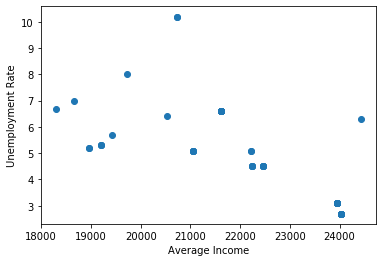

In [35]:
import matplotlib.pyplot as plt

plt.scatter(cities_merged['Avg Income'], cities_merged['Unemployment'])
plt.xlabel('Average Income')
plt.ylabel('Unemployment Rate')

Despite a few outliers, we can find a pattern that shows that a low unemployment rage in negatively related to the Average income per employee.

# Now we have to gather Latitude and Longitude of each city and the number of Italian restaurants and cafès in each one of these.

To do so, we use Nomatim module and Foursquare API

In [36]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
import json

In [37]:
# define a method that returns the latitude and longitude of a city
def get_latitude_and_longitude(city):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(city)
    if(location == None):
        raise ValueError('Error! Latitude and Longitude for city address: \'{}\' has not been found!'.format(city)) 
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

Next, we are going to get the list of cities from the dataframe, and we will build a list of dictionaries, in a dataframe fashion

In [38]:
from time import sleep

#get the city list from the dataframe
city_list = cities_merged['City'].tolist()

coords_list = []
for city in city_list:
    city_name = city + ', DE'
    lat, lng = get_latitude_and_longitude(city_name)
    coords_list.append({'City':city, 'Latitude': lat, 'Longitude': lng})
    sleep(0.2) #in this way we don't overload the 'geocoder' API

In [39]:
geo_df = pd.DataFrame(coords_list)
geo_df.head()

,City,Latitude,Longitude
0,Berlin,52.517037,13.388860
1,Hamburg,53.543764,10.009913
2,Munich,48.137108,11.575382
3,Nuremberg,49.453872,11.077298
4,Augsburg,48.366804,10.898697


In [40]:
CLIENT_ID = 'I5GS4YET4Q4BGGAJNQR1BIHL1K2BMIH21TG30EJOHDYO3NEO' # your Foursquare ID
CLIENT_SECRET = 'FROGEV44ZN3T3GRPUSWIM34I202RUJ3KX2EJ4P515OWRM1HA' # your Foursquare Secret
VERSION = '20200101' # Foursquare API version

Let's define a function *get_number_of_venues* that takes in input the latitude and longitude of a city, contacts the Foursquare API and retrieves the total number of venues around that geographical point

In [41]:
def get_number_of_venues(latitude, longitude, radius):
    LIMIT = 100

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius,
        LIMIT)
    
    response = requests.get(url).json()
    status = response['meta']['code']
    if ( status != 200 ): 
        print('Service invocation for url:',url,'has returned status',status,'... Returning 0')
        return 0
    else:
        return response['response']['totalResults']

The function *venues_from_api* is used to obtain a list of venues from the Foursquare API and convert the json response in a list of dictionaries.
Every venue is considered a dictionary with the following keys: Name, Category, Latitude, Longitude

In [45]:
def venues_from_api(url):
    venues = []
    json_response = requests.get(url).json()
    status = json_response['meta']['code']
    if ( status != 200 ): 
        print('Service invocation for url:',url,'has returned status',status,'... Returning empty collection')
        return []
    venue_list = json_response['response']['groups'][0]['items']
    for v in venue_list:
        venue = v['venue']
        name = venue['name']
        try:
            category = venue['categories'][0]['name']
            venues.append({'Name':name,'Category':category})
        except:
            continue
    
    return venues

The function *list_all_venues* takes in input the total number of venues in a city and fires a sequence of API calls to Foursquare to retrieve all the venues.
Unfortunately, it's not possible to make one single API call and retrieve all the venues. In fact, we are going to use the 'offset' string parameter in the endpoint to page through the venue results.
The maximum number for the 'offset' parameter is 50, so if for example a city has 210 venues, we need to make 5 API calls (0-50, 51-100, 101-150, 151-200, 201-209) changing the offset parameter.

In [46]:
def list_all_venues(total_results, latitude, longitude, radius = 800):
    all_venues = []

    OFFSET = 50
    if(total_results < OFFSET): total_results = OFFSET
    for i in range(0,1 + int(total_results/OFFSET)):
        tmp_offset = i*OFFSET
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius,
            OFFSET,
            tmp_offset   
        )

        tmp_venues = venues_from_api(url)
        all_venues = all_venues + tmp_venues
    
    return all_venues

Now, for each city in our dataframe, we will the list of all its venues within a certain radius.
Since we focus only on IT restaurants and cafes with 20 minutes of walking from the center, we can pick radius = 1500

In [47]:
RADIUS = 1500

city_amount_of_venues = []
for city_geodata in coords_list:
    city = city_geodata['City']
    lat = city_geodata['Latitude']
    lon = city_geodata['Longitude']
    
    num_of_IT_restaurants = 0
    num_of_cafès = 0
    
    num_of_venues = get_number_of_venues(lat,lon,RADIUS)
    city_venues = list_all_venues(num_of_venues, lat, lon, RADIUS)
    
    for venue in city_venues:
        if (venue['Category'] == 'Italian Restaurant'): num_of_IT_restaurants += 1
        if (venue['Category'] == 'Café'): num_of_cafès += 1
    
    city_amount_of_venues.append({'City':city, 'Num of IT Restaurants':num_of_IT_restaurants, 'Num of Cafès':num_of_cafès})

Service invocation for url: https://api.foursquare.com/v2/venues/explore?&client_id=I5GS4YET4Q4BGGAJNQR1BIHL1K2BMIH21TG30EJOHDYO3NEO&client_secret=FROGEV44ZN3T3GRPUSWIM34I202RUJ3KX2EJ4P515OWRM1HA&v=20200101&ll=49.453872,11.077298&radius=1500&limit=50&offset=50 has returned status 500 ... Returning empty collection
Service invocation for url: https://api.foursquare.com/v2/venues/explore?&client_id=I5GS4YET4Q4BGGAJNQR1BIHL1K2BMIH21TG30EJOHDYO3NEO&client_secret=FROGEV44ZN3T3GRPUSWIM34I202RUJ3KX2EJ4P515OWRM1HA&v=20200101&ll=49.453872,11.077298&radius=1500&limit=50&offset=100 has returned status 500 ... Returning empty collection


In [48]:
venues_df = pd.DataFrame(city_amount_of_venues)
venues_df.head()

,City,Num of IT Restaurants,Num of Cafès
0,Berlin,4,9
1,Hamburg,8,6
2,Munich,9,24
3,Nuremberg,3,9
4,Augsburg,5,5


In [49]:
final_df = pd.merge(left=cities_merged, right=venues_df, on='City')
final_df.head()

,City,State,Population,GDP,Unemployment,Avg Income,Num of IT Restaurants,Num of Cafès
0,Berlin,Berlin,3520031,68906,8.0,19719,4,9
1,Hamburg,Hamburg,1787408,92163,6.3,24421,8,6
2,Munich,Bavaria,1450381,100776,2.7,24026,9,24
3,Nuremberg,Bavaria,509975,72379,2.7,24026,3,9
4,Augsburg,Bavaria,286374,72062,2.7,24026,5,5


Finally, we gathered all the data we needed!